<a href="https://colab.research.google.com/github/julianoctvaz/PNL/blob/main/MainTextExtraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Esse extrator é modelo construido a partir de um dataset de clima, será utilizado com avaliação parcial na disciplina de Processamento de Linguagem Natural, 2020.2 - Cin UFPE



### Bibliotecas 

In [ ]:
#http://alexminnaar.com/2019/08/22/ner-rnns-tensorflow.html
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

import numpy as np
import os
import time

print(tf.__version__)

2.6.0


### Baixando dados 

In [ ]:
!wget https://raw.githubusercontent.com/julianoctvaz/PNL/main/TextExtraction/test.txt

--2021-08-18 12:20:03--  https://raw.githubusercontent.com/julianoctvaz/PNL/main/TextExtraction/test.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35217 (34K) [text/plain]
Saving to: ‘test.txt’

test.txt            100%[===================>]  34.39K  --.-KB/s    in 0.004s  

2021-08-18 12:20:03 (8.72 MB/s) - ‘test.txt’ saved [35217/35217]



In [ ]:
!wget https://raw.githubusercontent.com/julianoctvaz/PNL/main/TextExtraction/train.txt

--2021-08-18 12:20:03--  https://raw.githubusercontent.com/julianoctvaz/PNL/main/TextExtraction/train.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 164382 (161K) [text/plain]
Saving to: ‘train.txt’

train.txt           100%[===================>] 160.53K  --.-KB/s    in 0.03s   

2021-08-18 12:20:04 (5.50 MB/s) - ‘train.txt’ saved [164382/164382]



In [ ]:
!wget https://raw.githubusercontent.com/julianoctvaz/PNL/main/TextExtraction/valid.txt

--2021-08-18 12:20:04--  https://raw.githubusercontent.com/julianoctvaz/PNL/main/TextExtraction/valid.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 34448 (34K) [text/plain]
Saving to: ‘valid.txt’

valid.txt           100%[===================>]  33.64K  --.-KB/s    in 0s      

2021-08-18 12:20:04 (81.1 MB/s) - ‘valid.txt’ saved [34448/34448]



In [ ]:
labels = set()

def file2Examples(file_name):
  '''
  Read data files and return input/output pairs
  '''
  
  examples=[]

  with open(file_name,"r") as f:

    next(f)
    next(f)

    example = [[],[]]

    for line in f:
      input_output_split= line.split()

      if len(input_output_split)==2:
        example[0].append(input_output_split[0])
        example[1].append(input_output_split[-1])
        labels.add(input_output_split[-1])

      elif len(input_output_split)==0:
        examples.append(example)
        example=[[],[]]
        
      else:
        example=[[],[]]

    f.close()

    return examples

train_examples = file2Examples("train.txt")
test_examples = file2Examples("test.txt")
valid_examples = file2Examples("valid.txt")

### Verificando se tagging foi concluído com sucesso

In [ ]:
!head train.txt

What O
will O
the O
weather O
be O
this B-timeRange
year I-timeRange
in O
Horseshoe B-geographic_poi
Lake I-geographic_poi


### Dimensões (entities) mapeados do dataset para o formato BIO-Label, tagging de categorias
##### esse preprocessamento para BIO-Label com javascript, mais detalhes verificar repositório

In [ ]:

# create character vocab
all_text = " ".join([" ".join(x[0]) for x in train_examples+valid_examples+test_examples])
vocab = sorted(set(all_text))

# create character/id and label/id mapping
char2idx = {u:i+1 for i, u in enumerate(vocab)}
idx2char = np.array(vocab)
label2idx = {u:i+1 for i, u in enumerate(labels)}
idx2label = np.array(labels)

print(idx2label)
print(char2idx)

{'I-current_location', 'I-state', 'O', 'I-geographic_poi', 'I-city', 'B-country', 'I-country', 'I-spatial_relation', 'B-geographic_poi', 'I-timeRange', 'B-condition_temperature', 'B-city', 'B-timeRange', 'B-current_location', 'B-condition_description', 'B-state', 'B-spatial_relation'}
{' ': 1, '0': 2, '1': 3, '2': 4, '3': 5, '4': 6, '5': 7, '6': 8, '7': 9, '8': 10, '9': 11, 'A': 12, 'B': 13, 'C': 14, 'D': 15, 'E': 16, 'F': 17, 'G': 18, 'H': 19, 'I': 20, 'J': 21, 'K': 22, 'L': 23, 'M': 24, 'N': 25, 'O': 26, 'P': 27, 'Q': 28, 'R': 29, 'S': 30, 'T': 31, 'U': 32, 'V': 33, 'W': 34, 'X': 35, 'Y': 36, 'Z': 37, 'a': 38, 'b': 39, 'c': 40, 'd': 41, 'e': 42, 'f': 43, 'g': 44, 'h': 45, 'i': 46, 'j': 47, 'k': 48, 'l': 49, 'm': 50, 'n': 51, 'o': 52, 'p': 53, 'q': 54, 'r': 55, 's': 56, 't': 57, 'u': 58, 'v': 59, 'w': 60, 'x': 61, 'y': 62, 'z': 63}


### Criando variaveis dado o data split

In [ ]:
def split_char_labels(eg):
  '''
  For a given input/output example, break tokens into characters while keeping 
  the same label.
  '''

  tokens = eg[0]
  labels=eg[1]

  input_chars = []
  output_char_labels = []

  for token,label in zip(tokens,labels):

    input_chars.extend([char for char in token])
    input_chars.extend(' ')
    output_char_labels.extend([label]*len(token))
    output_char_labels.extend('O')

  return [[char2idx[x] for x in input_chars[:-1]],np.array([label2idx[x] for x in output_char_labels[:-1]])]

train_formatted = [split_char_labels(eg) for eg in train_examples]
test_formatted = [split_char_labels(eg) for eg in test_examples]
valid_formatted = [split_char_labels(eg) for eg in valid_examples]

print(len(train_formatted))
print(len(test_formatted))
print(len(valid_formatted))

1400
300
300


### Construindo o Modelo LSTM

In [ ]:
 #training generator
def gen_train_series():
  for eg in train_formatted:
     yield eg[0],eg[1]

# validation generator
def gen_valid_series():
  for eg in valid_formatted:
     yield eg[0],eg[1]

# test generator
def gen_test_series():
  for eg in test_formatted:
      yield eg[0],eg[1]
      
# create Dataset objects for train, test and validation sets  
series = tf.data.Dataset.from_generator(gen_train_series,output_types=(tf.int32, tf.int32),output_shapes = ((None, None)))
series_valid = tf.data.Dataset.from_generator(gen_valid_series,output_types=(tf.int32, tf.int32),output_shapes = ((None, None)))
series_test = tf.data.Dataset.from_generator(gen_test_series,output_types=(tf.int32, tf.int32),output_shapes = ((None, None)))

BATCH_SIZE = 128
BUFFER_SIZE=1000

# create padded batch series objects for train, test and validation sets
ds_series_batch = series.shuffle(BUFFER_SIZE).padded_batch(BATCH_SIZE, padded_shapes=([None], [None]), drop_remainder=True)
ds_series_batch_valid = series_valid.padded_batch(BATCH_SIZE, padded_shapes=([None], [None]), drop_remainder=True)
ds_series_batch_test = series_test.padded_batch(BATCH_SIZE, padded_shapes=([None], [None]), drop_remainder=True)
  
  # print example batches
for input_example_batch, target_example_batch in ds_series_batch_valid.take(1):
  print(input_example_batch)
  print(target_example_batch)

tf.Tensor(
[[57 45 42 ...  0  0  0]
 [20 56  1 ...  0  0  0]
 [34 45 38 ...  0  0  0]
 ...
 [60 45 38 ...  0  0  0]
 [34 46 49 ...  0  0  0]
 [34 45 38 ...  0  0  0]], shape=(128, 96), dtype=int32)
tf.Tensor(
[[3 3 3 ... 0 0 0]
 [3 3 3 ... 0 0 0]
 [3 3 3 ... 0 0 0]
 ...
 [3 3 3 ... 0 0 0]
 [3 3 3 ... 0 0 0]
 [3 3 3 ... 0 0 0]], shape=(128, 96), dtype=int32)


In [ ]:
vocab_size = len(vocab)+1

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 1024

label_size = len(labels)  

# build LSTM model
def build_model(vocab_size,label_size, embedding_dim, rnn_units, batch_size):
      model = tf.keras.Sequential([
          tf.keras.layers.Embedding(vocab_size, embedding_dim,
                            batch_input_shape=[batch_size, None],mask_zero=True),
          tf.keras.layers.LSTM(rnn_units,
                      return_sequences=True,
                      stateful=True,
                      recurrent_initializer='glorot_uniform'),
          tf.keras.layers.Dense(label_size)
          ])
      return model

model = build_model(
      vocab_size = len(vocab)+1,
      label_size=len(labels)+1,
      embedding_dim=embedding_dim,
      rnn_units=rnn_units,
      batch_size=BATCH_SIZE)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (128, None, 256)          16384     
_________________________________________________________________
lstm (LSTM)                  (128, None, 1024)         5246976   
_________________________________________________________________
dense (Dense)                (128, None, 18)           18450     
Total params: 5,281,810
Trainable params: 5,281,810
Non-trainable params: 0
_________________________________________________________________


### Loss function com Sparse Categorical Crossentropy e optimizador adam, 
##### Essa configuração de paramêtros foi o que trouxe os melhores resultados

In [ ]:

# define loss function
def loss(labels, logits):
    return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

model.compile(optimizer='adam', loss=loss,metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

In [ ]:
EPOCHS=20

history = model.fit(ds_series_batch, epochs=EPOCHS, validation_data=ds_series_batch_valid,callbacks=[checkpoint_callback])

Epoch 1/20
10/10 [==============================] - 125s 12s/step - loss: 1.1511 - sparse_categorical_accuracy: 0.5065 - val_loss: 1.0665 - val_sparse_categorical_accuracy: 0.5803
Epoch 2/20
10/10 [==============================] - 117s 12s/step - loss: 0.8740 - sparse_categorical_accuracy: 0.5661 - val_loss: 0.9018 - val_sparse_categorical_accuracy: 0.5803
Epoch 3/20
10/10 [==============================] - 113s 11s/step - loss: 0.8485 - sparse_categorical_accuracy: 0.5635 - val_loss: 0.8449 - val_sparse_categorical_accuracy: 0.5807
Epoch 4/20
10/10 [==============================] - 117s 12s/step - loss: 0.8047 - sparse_categorical_accuracy: 0.5559 - val_loss: 0.8212 - val_sparse_categorical_accuracy: 0.5817
Epoch 5/20
10/10 [==============================] - 113s 11s/step - loss: 0.7775 - sparse_categorical_accuracy: 0.5705 - val_loss: 0.7974 - val_sparse_categorical_accuracy: 0.5846
Epoch 6/20
10/10 [==============================] - 115s 11s/step - loss: 0.7262 - sparse_categorica

### Métricas

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

preds = np.array([])
y_trues= np.array([])

# iterate through test set, make predictions based on trained model
for input_example_batch, target_example_batch in ds_series_batch_test:

  pred=model.predict_on_batch(input_example_batch)
  pred_max=tf.argmax(tf.nn.softmax(pred),2).numpy().flatten()
  y_true=target_example_batch.numpy().flatten()

  preds=np.concatenate([preds,pred_max])
  y_trues=np.concatenate([y_trues,y_true])

# remove padding from evaluation
remove_padding = [(p,y) for p,y in zip(preds,y_trues) if y!=0]

r_p = [x[0] for x in remove_padding]
r_t = [x[1] for x in remove_padding]

# print confusion matrix and classification report
print(confusion_matrix(r_p,r_t))
print(classification_report(r_p,r_t))

[[  83    0    6    0    0    0    0    0    0    0    0    0    0    0
     0    0    3]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0]
 [   0    7 6543   74   32   14   25   41   10  249  182   54  317   49
   180   55   95]
 [   0   19  111  689   60   81   68    0    2    2    3   25   22    0
     4   78    9]
 [   0    1    0   10   32   11    7    0    0    0    0    0    0    0
     0    7    0]
 [   0   21   35   83   82   45   12    0   15    0    0   15    8    0
     0   13    0]
 [   0    0    0    2    0    0    0    0    0    0    2    1    1    0
     1    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0]
 [   0    0    2    0    0    0    0    0    0    0    0    0    0    0
     0    0    0]
 [   0    0  133    0    0    2    0    0    1  590    3    8  109   25
    14    5   13]
 [   0    0   15    0    0    0    0    0    0    3  103    0    0    2
    22    0    0]
 [   0    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


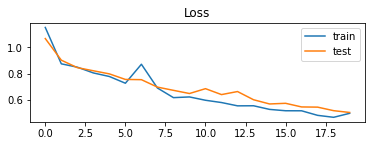

In [ ]:
from matplotlib import pyplot

# plot loss during training
pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()


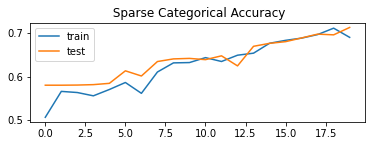

In [ ]:
# plot sparse categorical accuracy during training

pyplot.subplot(212)
pyplot.title(' Sparse Categorical Accuracy')
pyplot.plot(history.history['sparse_categorical_accuracy'], label='train')
pyplot.plot(history.history['val_sparse_categorical_accuracy'], label='test')
pyplot.legend()
pyplot.show()